In [11]:
from __future__ import absolute_import
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import cohorts
from cohorts.functions import missense_snv_count, snv_count
from query_tcga import cohort

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initializing the cohort

In this example, we will demonstrate how to use [query_tcga](http://github.com/jburos/query_tcga) to initialize a cohort object. We will then do some simple mock-analyses using this object.

This proceeds in two steps:
  1. `prep_patients()`: create a list of Patients (objects of class `cohort.Patient`)
  2. `prep_cohort()`: create a Cohort from the list of patients (object class `cohorts.Cohort`)

For example, to query the `BLCA` cohort:

In [12]:
blca_patients = cohort.prep_patients(project_name='TCGA-BLCA',
                                     project_data_dir='data',
                                     data_dir='data/gdc')

blca_cohort = cohort.prep_cohort(patients=blca_patients,
                                 cache_dir='data-cache3')

{'dataframe_hash': -6111177348469020104, 'provenance_file_summary': None}


We are now ready to proceed with our analysis.

## Analysis of outcomes: Survival by Somatic Mutation Burden

In this cohort, we have VCF data so we can plot survival according to `snv_count`.

`plot_survival` plots `OS` as the outcome, using the median value as the threshold.

# no condition 71
# with condition 70


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.19330 |              1.692 |  Cannot Reject Null |       False       
>

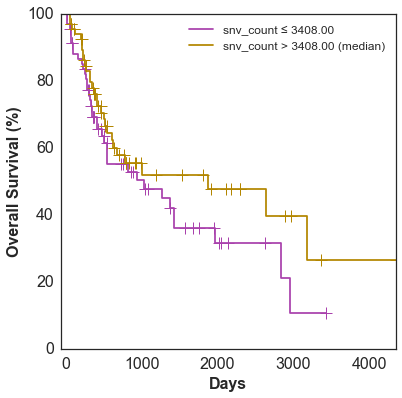

In [13]:
blca_cohort.plot_survival(snv_count)

There are a number of functions pre-defined in `cohorts` which provide common summaries of genetic data. 

Some examples:

 - `snv_count` summarizes the number of somatic SNVs per patient
 - `missense_snv_count` summarizes the number of missense SNVs per patient
 - `neoantigen_count` counts number of predicted neoantigens, after running topiary on VCFs
 - `expressed_snv_count` same as `snv_count` but filtered to expressed variants

Note that not every function will work for every cohort. If your cohort does not have mRNA data, for example, the `expressed_snv_count` function will produce an error. 

## Analysis of outcomes: Benefit by SNV count

Alternatively, we might want to summarize the association of SNV count with `benefit`, which is defined as OS > 1 year by default (see `?cohort.prep_patients`). 

To accomplish this, we can use the `plot_benefit` function for the cohort:

Mann-Whitney test: U=2337.0, p-value=0.643264297939 (two-sided)


MannWhitneyResults(U=2337.0, p_value=0.643264297939, sided_str='two-sided')

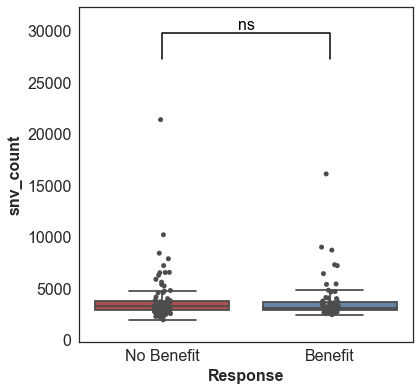

In [73]:
blca_cohort.plot_benefit(cohorts.functions.snv_count)

## Data exploration: Correlation of SNV count with Age

We might want to summarize correlation between `snv_count` and `age at diagnosis`. 

One peculiarity of the `plot_correlation` function is that it currently requires a function as input. Unlike `plot_survival` and `plot_benefit`, you cannot pass a variable name as a string.

So, for now, we create a mini-function to return the desired variable:

In [20]:
def age_at_dx(row):
    return row['age']

CorrelationResults(coeff=-0.0470557604077, p_value=0.579517637023, stat_func=pearsonr)

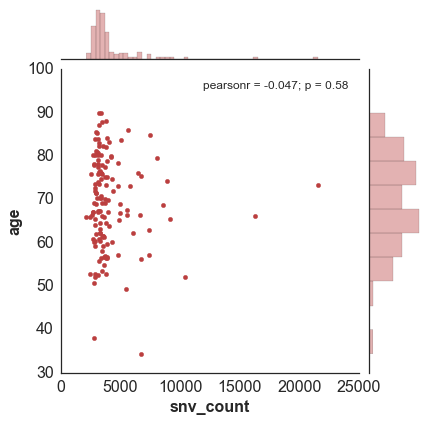

In [19]:
blca_cohort.plot_correlation(snv_count, age_at_dx)

As before, we can alternatively plot `snv_count` by benefit :

## More flexibility: Prepare dataframe for analysis

Finally, we can retrieve the cohort data as a dataframe, including calculated functions like `snv_count`, etc. 

This is to enable opportunities for more detailed data exploration and/or analysis using external libraries.

Here it is possible to provide a list of functions so that multiple summary statistics can be computed in the same dataframe.

In [14]:
extra_cols, df = blca_cohort.as_dataframe(on=[cohorts.functions.snv_count])
print(extra_cols)

['snv_count']


Also note that **the function now returns a tuple** when a list is passed to the parameter `on`. 
    (By comparison, when no `on` parameter is given, `as_dataframe()` simply returns a dataframe.)

## Other options to `prep_cohort`:

The idea behind `cohorts` is to encourage the majority of analyses to use the "standard" options for this particular cohort. 

Thus, the user can set various *default* options at a cohort-level at the time of creation, but then override these on an analysis-by-analysis basis as needed.

Examples of options that utilize this framework include:
   - `normalized_per_mb`: whether to normalize metrics like SNV count to coverage
   - `filter_fn`: QC filters to apply to *all variants* prior to summary stats being calculated
   - `plot_benefit_name`: Descriptor to use for "benefit" plots 
   - etc.
   
See `?cohorts.Cohort` for a more complete list of options.
